In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

import logging

from sklearn.metrics import mean_absolute_error


In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [3]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2009]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]

#### Take Out Trend

In [4]:
LME = LME.resample('B').sum()

LME

LME_log = np.log(LME)

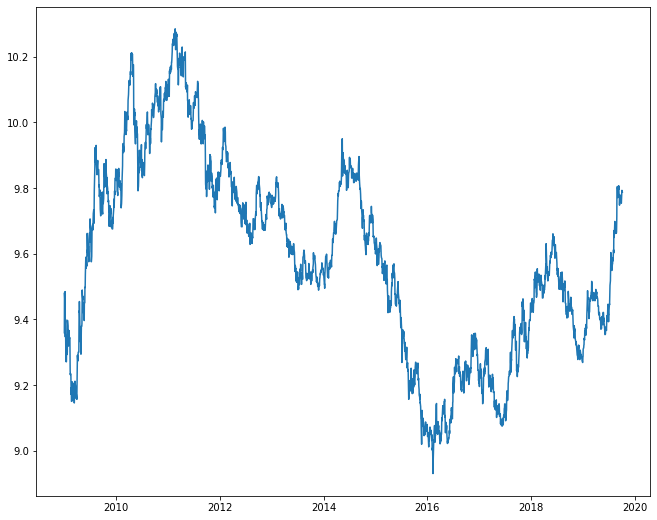

In [79]:
rcParams['figure.figsize'] = 11, 9

plt.plot(LME_log)
plt.show()

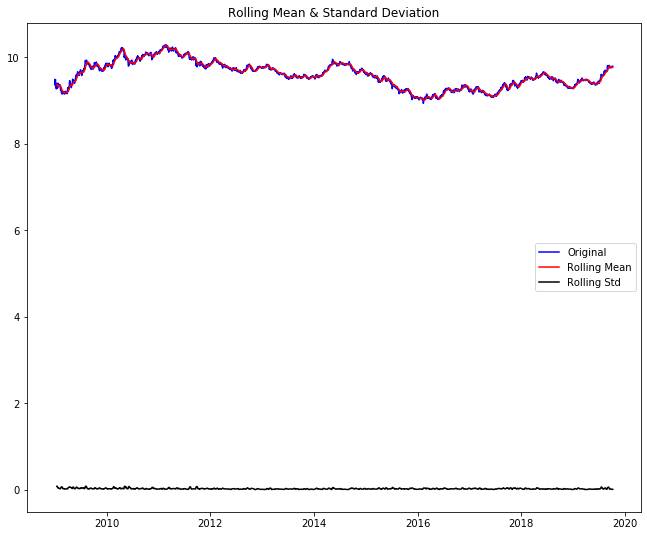

Results of Dickey-Fuller Test:
Test Statistic                   -1.795232
p-value                           0.382832
#Lags Used                        0.000000
Number of Observations Used    2807.000000
Critical Value (1%)              -3.432682
Critical Value (5%)              -2.862570
Critical Value (10%)             -2.567318
dtype: float64


In [80]:
test_stationarity(LME_log)

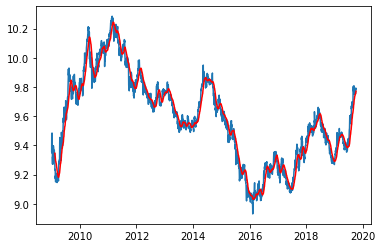

In [76]:
moving_avg = LME_log.rolling(window=30).mean()
plt.plot(LME_log)
plt.plot(moving_avg, color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

<class 'pandas.core.series.Series'>


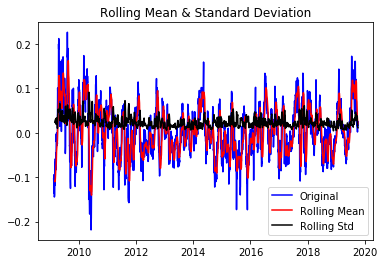

Results of Dickey-Fuller Test:
Test Statistic                -9.033624e+00
p-value                        5.361918e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.769000e+03
Critical Value (1%)           -3.432714e+00
Critical Value (5%)           -2.862584e+00
Critical Value (10%)          -2.567326e+00
dtype: float64


In [58]:
moving_diff = LME_log-moving_avg
moving_diff = moving_diff.dropna()
#moving_diff = moving_diff.to_frame()
print(type(moving_diff))
test_stationarity(moving_diff)


In [59]:
logging.getLogger().setLevel(logging.ERROR)

In [60]:
list_one = list(moving_diff.index)
list_two = list(moving_diff)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])
moving_diff

prediction_size = 365
train_df = df[:-prediction_size]

m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods = prediction_size)

forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2774,2019-05-10,0.007860,-0.045467,0.092954,0.006275,0.009424,0.016007,0.016007,0.016007,0.022892,0.022892,0.022892,-0.006886,-0.006886,-0.006886,0.0,0.0,0.0,0.023867
2775,2019-05-11,0.007891,-0.131441,0.017944,0.006300,0.009461,-0.065995,-0.065995,-0.065995,-0.056927,-0.056927,-0.056927,-0.009068,-0.009068,-0.009068,0.0,0.0,0.0,-0.058104
2776,2019-05-12,0.007922,-0.132919,0.012473,0.006324,0.009499,-0.068114,-0.068114,-0.068114,-0.056927,-0.056927,-0.056927,-0.011187,-0.011187,-0.011187,0.0,0.0,0.0,-0.060191
2777,2019-05-13,0.007953,-0.052317,0.094650,0.006347,0.009536,0.010283,0.010283,0.010283,0.023515,0.023515,0.023515,-0.013232,-0.013232,-0.013232,0.0,0.0,0.0,0.018237
2778,2019-05-14,0.007984,-0.058612,0.083745,0.006371,0.009571,0.006842,0.006842,0.006842,0.022036,0.022036,0.022036,-0.015194,-0.015194,-0.015194,0.0,0.0,0.0,0.014827


In [61]:
test_df = df[-prediction_size:]

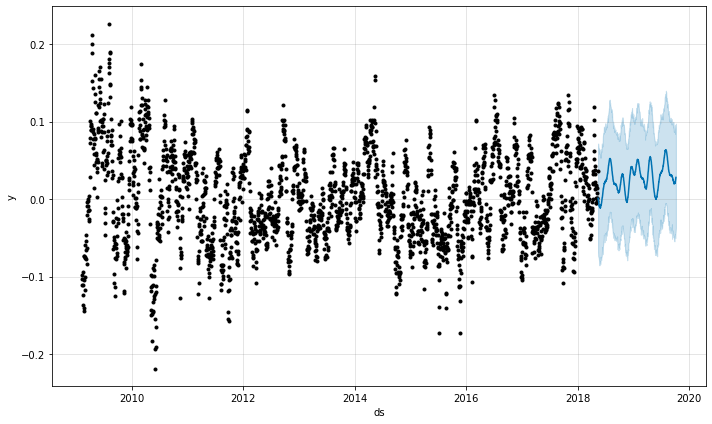

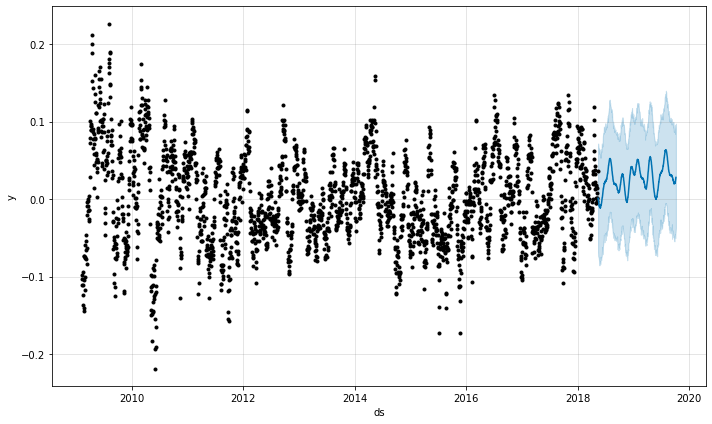

In [62]:
forecast = m.predict(test_df)
m.plot(forecast)

In [63]:
forecast.tail(20)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
345,2019-09-10,0.011681,-0.041051,0.098028,0.008950,0.014157,0.017660,0.017660,0.017660,0.022036,0.022036,0.022036,-0.004376,-0.004376,-0.004376,0.0,0.0,0.0,0.029341
346,2019-09-11,0.011712,-0.032436,0.102958,0.008973,0.014197,0.018339,0.018339,0.018339,0.023118,0.023118,0.023118,-0.004779,-0.004779,-0.004779,0.0,0.0,0.0,0.030051
347,2019-09-12,0.011743,-0.051079,0.097010,0.008990,0.014236,0.017024,0.017024,0.017024,0.022292,0.022292,0.022292,-0.005268,-0.005268,-0.005268,0.0,0.0,0.0,0.028767
348,2019-09-13,0.011774,-0.040163,0.098307,0.009007,0.014274,0.017054,0.017054,0.017054,0.022892,0.022892,0.022892,-0.005838,-0.005838,-0.005838,0.0,0.0,0.0,0.028828
349,2019-09-16,0.011867,-0.040350,0.099832,0.009078,0.014389,0.015548,0.015548,0.015548,0.023515,0.023515,0.023515,-0.007967,-0.007967,-0.007967,0.0,0.0,0.0,0.027415
350,2019-09-17,0.011898,-0.048773,0.098046,0.009104,0.014429,0.013259,0.013259,0.013259,0.022036,0.022036,0.022036,-0.008777,-0.008777,-0.008777,0.0,0.0,0.0,0.025157
351,2019-09-18,0.011929,-0.042379,0.093365,0.009130,0.014472,0.013507,0.013507,0.013507,0.023118,0.023118,0.023118,-0.009611,-0.009611,-0.009611,0.0,0.0,0.0,0.025436
352,2019-09-19,0.011960,-0.046883,0.092600,0.009156,0.014515,0.011842,0.011842,0.011842,0.022292,0.022292,0.022292,-0.010450,-0.010450,-0.010450,0.0,0.0,0.0,0.023802
353,2019-09-20,0.011991,-0.046950,0.099729,0.009182,0.014558,0.011617,0.011617,0.011617,0.022892,0.022892,0.022892,-0.011275,-0.011275,-0.011275,0.0,0.0,0.0,0.023609
354,2019-09-23,0.012085,-0.048923,0.088282,0.009260,0.014681,0.010061,0.010061,0.010061,0.023515,0.023515,0.023515,-0.013454,-0.013454,-0.013454,0.0,0.0,0.0,0.022146


In [64]:
forecast.index = forecast['ds']
forecast['yhat']

ds
2018-05-15    0.001197
2018-05-16    0.000562
2018-05-17   -0.001874
2018-05-18   -0.002774
2018-05-21   -0.005936
2018-05-22   -0.008425
2018-05-23   -0.008221
2018-05-24   -0.009788
2018-05-25   -0.009791
2018-05-28   -0.010110
2018-05-29   -0.011608
2018-05-30   -0.010394
2018-05-31   -0.010939
2018-06-01   -0.009909
2018-06-04   -0.007131
2018-06-05   -0.007622
2018-06-06   -0.005430
2018-06-07   -0.005033
2018-06-08   -0.003109
2018-06-11    0.001953
2018-06-12    0.002058
2018-06-13    0.004747
2018-06-14    0.005536
2018-06-15    0.007739
2018-06-18    0.012939
2018-06-19    0.012856
2018-06-20    0.015249
2018-06-21    0.015638
2018-06-22    0.017349
2018-06-25    0.020648
                ...   
2019-08-27    0.031147
2019-08-28    0.031809
2019-08-29    0.030680
2019-08-30    0.031078
2019-09-02    0.031520
2019-09-03    0.030056
2019-09-04    0.031157
2019-09-05    0.030336
2019-09-06    0.030908
2019-09-09    0.031109
2019-09-10    0.029341
2019-09-11    0.030051
2019-09-

## Back to Scale before Performance Analysis

In [65]:
yhat = forecast['yhat']
y = moving_diff['2018-05-15':]
shifted_by_avg = moving_avg['2018-05-15':]

In [66]:
scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]
scaled_yhat

scaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]
scaled_y

actual_y = LME_log['2018-05-15':]


In [67]:
frame = { 'scaled_yhat': scaled_yhat, 'scaled_y': scaled_y, 'actual y': actual_y } 
  
results = pd.DataFrame(frame) 
results.head()

,scaled_yhat,scaled_y,actual y
2018-05-15,9.544669,9.571784,9.571784
2018-05-16,9.547197,9.575192,9.575192
2018-05-17,9.547775,9.583902,9.583902
2018-05-18,9.550387,9.594820,9.594820
2018-05-21,9.550126,9.589290,9.589290


In [68]:
results['error'] = results['scaled_y'] - results['scaled_yhat']
results.head()

results['unlogged_scaled_yhat'] = np.exp(results['scaled_yhat'])
results['original_y'] = LME['2018-05-15':]


In [69]:
results['error'] = results['original_y'] - results['unlogged_scaled_yhat']

# Mean error results
print(np.abs(results['error']).mean())

615.3641910479995


In [77]:
results.head()

,scaled_yhat,scaled_y,actual y,error,unlogged_scaled_yhat,original_y
2018-05-15,9.544669,9.571784,9.571784,383.973634,13970.026366,14354.0
2018-05-16,9.547197,9.575192,9.575192,397.618819,14005.381181,14403.0
2018-05-17,9.547775,9.583902,9.583902,515.514446,14013.485554,14529.0
2018-05-18,9.550387,9.594820,9.594820,638.367074,14050.132926,14688.5
2018-05-21,9.550126,9.589290,9.589290,561.034667,14046.465333,14607.5


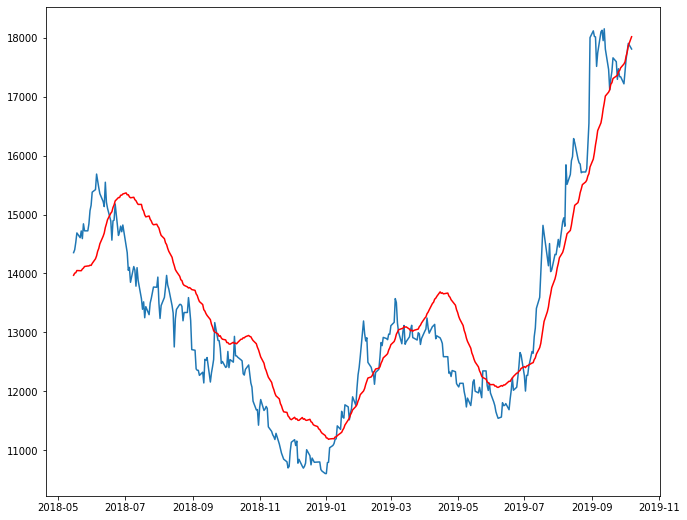

In [81]:
plt.plot(results['original_y'])
plt.plot(results['unlogged_scaled_yhat'], color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

In [43]:
mean_absolute_error(results['scaled_y'], results['scaled_yhat'] )


0.04589771120721824

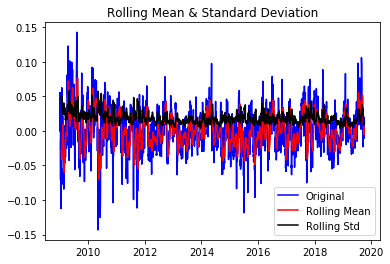

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [31]:
exponential_diff = LME_log-exponential_weight
exponential_diff = exponential_diff.dropna()
test_stationarity(exponential_diff)

In [30]:
exdiff = exponential_diff
exdiff

NameError: name 'exponential_diff' is not defined

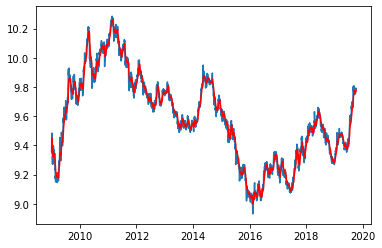

In [29]:
exponential_weight = LME_log.ewm(span=12).mean()
plt.plot(LME_log)

plt.plot(exponential_weight, color='red')

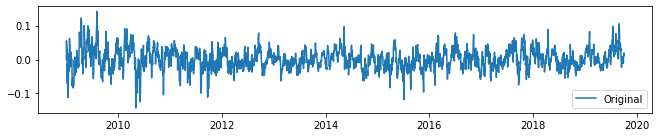

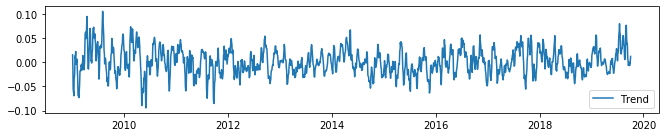

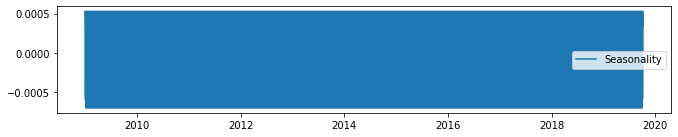

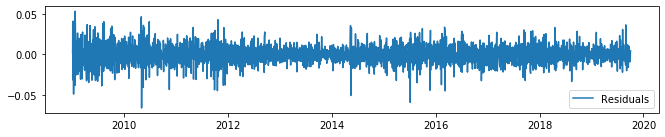

In [186]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(exdiff)
#fig = decomposition.plot()
#plt.show()

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(exdiff, label='Original')
plt.legend(loc='best')
plt.show()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.show()

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.show()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [187]:
exdiff.to_csv('exdiff_preprocessed.csv', index=True, header=True)

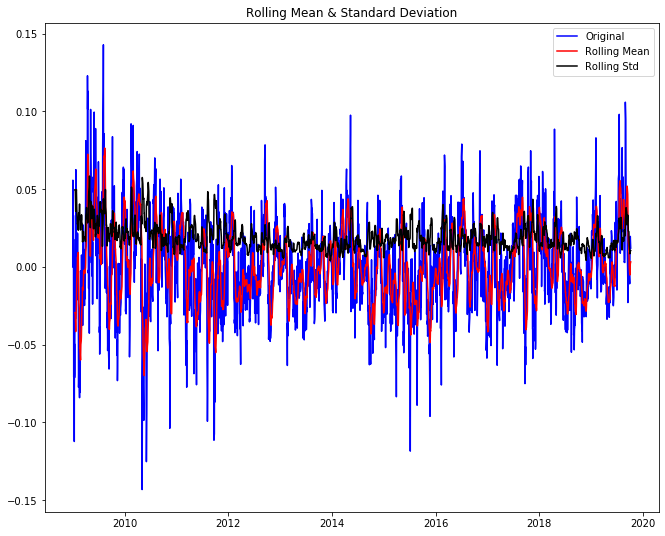

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [66]:
df = pd.read_csv('exdiff_preprocessed.csv')
df.index = df['Unnamed: 1']
df = df.iloc[:, 1:]
df.head()

df = df['Cash Price ($/MT)'].squeeze()
df.index = pd.to_datetime(df.index)
test_stationarity(df)

# Modeling

https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

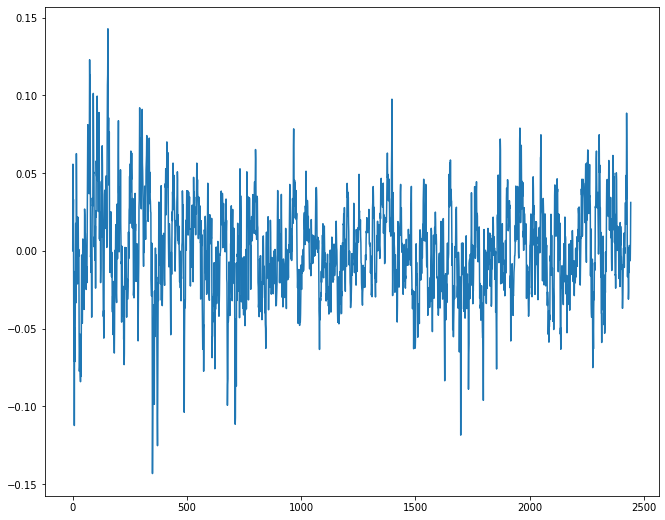

In [174]:
plt.plot(train_df['y'])

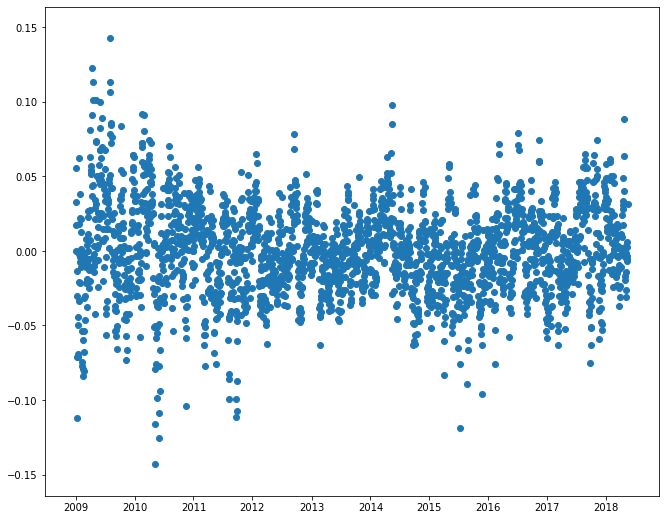

In [176]:
plt.scatter(train_df['ds'], train_df['y'])

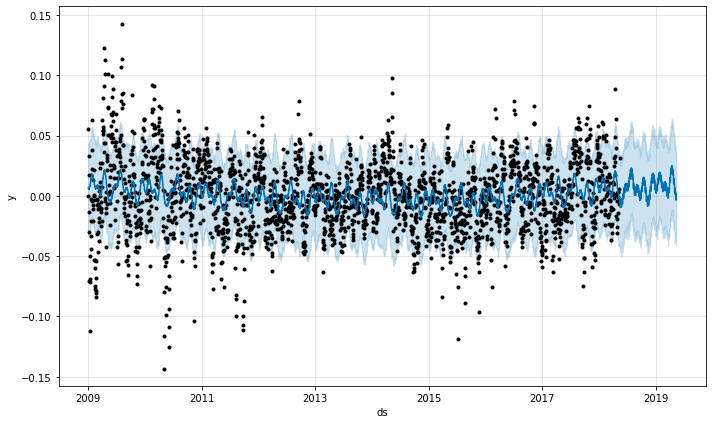

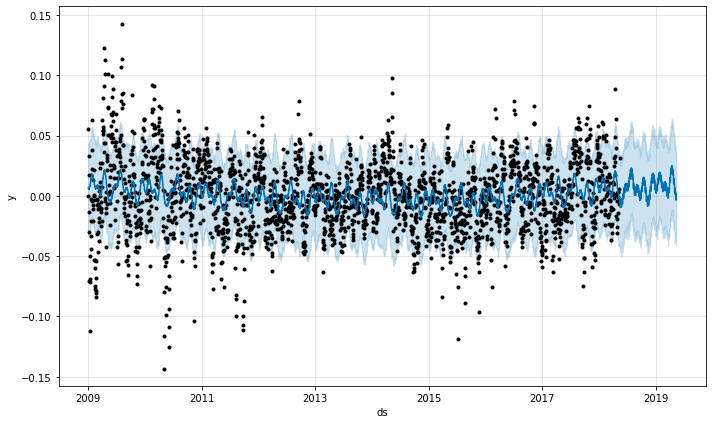

In [88]:
m.plot(forecast)

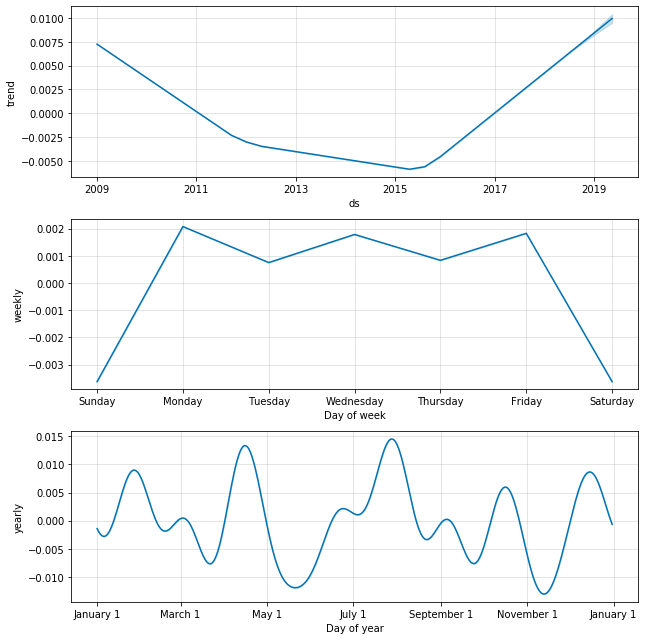

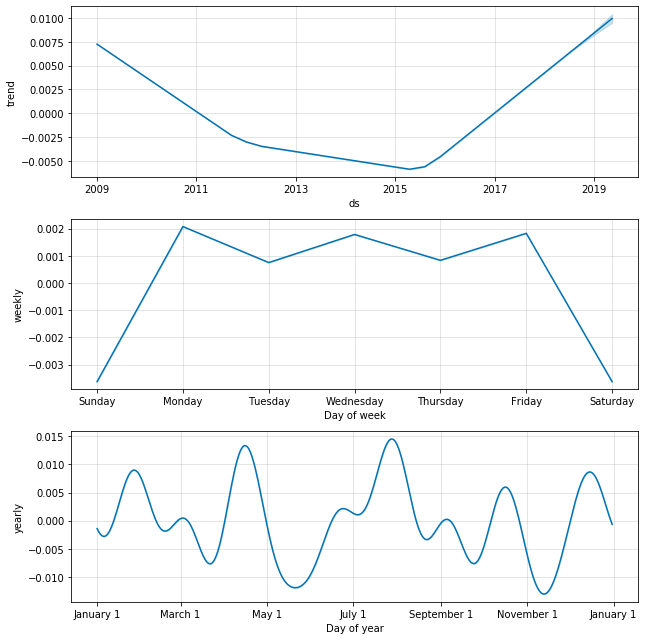

In [89]:
m.plot_components(forecast)

In [42]:
'''Joins predicted values with actual values'''
def make_comparison_dataframe(historical, forecast):
    
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Creating comparison dataframe
cmp_df = make_comparison_dataframe(df, forecast)



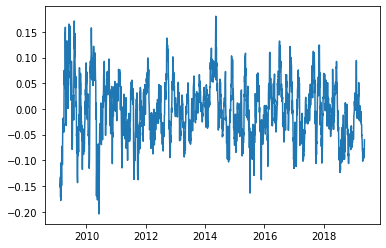

In [49]:
cmp_df['error'] =  cmp_df['y'] - cmp_df['yhat']
cmp_df.head()
plt.plot(cmp_df['error'])

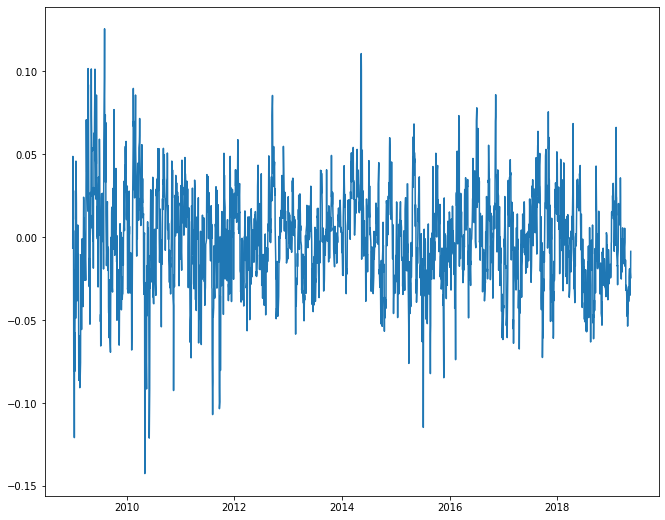

In [151]:
plt.plot(cmp_df['error'])

In [51]:
cmp_df = cmp_df.dropna()

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['error'] = df['y'] - df['yhat']
    df['percentage'] = 100*df['error']/df['y']
    
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    print(predicted_part.head())
    return {'MAPE': error_mean('percentage'), 'MAE': error_mean('error')}

for err_name, err_value in calculate_forecast_errors(cmp_df.dropna(), prediction_size).items():
    print(err_name, err_value)

                yhat  yhat_lower  yhat_upper         y     error  percentage
ds                                                                          
2017-12-20  0.030911   -0.038317    0.101200  0.042610  0.011699   27.455771
2017-12-21  0.030106   -0.045255    0.099914  0.046177  0.016070   34.801897
2017-12-22  0.030545   -0.037697    0.100828  0.051237  0.020692   40.384256
2017-12-25  0.029742   -0.038494    0.100844  0.052215  0.022473   43.039938
2017-12-26  0.027537   -0.041608    0.098748  0.051225  0.023688   46.242715
MAPE 570.8182329084178
MAE 0.04271461087194927


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [46]:
np.sqrt(9)

3.0

In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
